In [42]:
from __future__ import annotations

import math
import time
from typing import List, Tuple

import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import scipy as sp
import scipy.optimize
import scipy.sparse
from networkx.drawing.layout import _process_params
from tqdm.auto import tqdm

from src.python.cost import calcCost
from src.python.vis.visGraph import visGraph

# https://www.redblobgames.com/grids/hexagons/


class Hex:
    def __init__(self, q: int, r: int):
        self.q = q
        self.r = r
        # self.s = -q - r

    def __add__(self, other: Hex):
        return Hex(self.q + other.q, self.r + other.r)

    def __sub__(self, other: Hex):
        return Hex(self.q - other.q, self.r - other.r)

    def __eq__(self, other: Hex):
        return self.q == other.q and self.r == other.r

    def __ne__(self, other: Hex):
        return not self.__eq__(other)

    def __str__(self):
        return f"Hex({self.q}, {self.r})"

    def __repr__(self):
        return self.__str__()

    def hex2xy(self, k: float) -> Tuple[float, float]:
        return k * (self.q + self.r / 2), k * (self.r * pow(3, 0.5) / 2)

    def length(self) -> int:
        return (abs(self.q) + abs(self.r) + abs(-self.q - self.r)) // 2

    def distance(self, other: Hex) -> int:
        return self.__sub__(other).length()

    @staticmethod
    def xy2hex(x: float, y: float, k: float) -> Hex:
        r = round(y * 2.0 / (k * pow(3, 0.5)))
        q = round(x / k - r / 2)
        return Hex(q, r, -q - r)

    @staticmethod
    def round(q: float, r: float, s: float) -> Hex:
        qi = int(round(q))
        ri = int(round(r))
        si = int(round(s))
        q_diff = abs(qi - q)
        r_diff = abs(ri - r)
        s_diff = abs(si - s)
        if q_diff > r_diff and q_diff > s_diff:
            qi = -ri - si
        elif r_diff > s_diff:
            ri = -qi - si
        return Hex(qi, ri)

    @staticmethod
    def lerp(
        a_q: float, a_r: float, a_s: float, b_q: float, b_r: float, b_s: float, t: float
    ) -> Hex:
        return Hex.round(
            a_q * (1.0 - t) + b_q * t,
            a_r * (1.0 - t) + b_r * t,
            a_s * (1.0 - t) + b_s * t,
        )

    @staticmethod
    def linedraw(a: Hex, b: Hex) -> List[Hex]:
        N = a.distance(b)
        a_s, b_s = -a.q - a.r, -b.q - b.r
        a_nudge_q, a_nudge_r, a_nudge_s = a.q + 1e-06, a.r + 1e-06, a_s - 2e-06
        b_nudge_q, b_nudge_r, b_nudge_s = b.q + 1e-06, b.r + 1e-06, b_s - 2e-06
        results = []
        step = 1.0 / max(N, 1)
        for i in range(0, N + 1):
            results.append(
                Hex.lerp(
                    a_nudge_q,
                    a_nudge_r,
                    a_nudge_s,
                    b_nudge_q,
                    b_nudge_r,
                    b_nudge_s,
                    step * i,
                )
            )
        return results

    @staticmethod
    def equal_hex_array(a: List[Hex], b: List[Hex]) -> bool:
        if len(a) != len(b):
            return False
        return all(ai == bi for ai, bi in zip(a, b))


assert Hex.equal_hex_array(
    [Hex(0, 0), Hex(0, -1), Hex(0, -2), Hex(1, -3), Hex(1, -4), Hex(1, -5)],
    Hex.linedraw(Hex(0, 0), Hex(1, -5)),
)


class Grid:
    def __init__(self, n: int, k: float):
        self.n = n
        self.k = k

        self.n2 = 0
        while 3 * self.n2**2 + 3 * self.n2 + 1 < n:
            self.n2 += 1

        self.points = []
        for r in range(0, 2 * self.n2 + 1):
            for q in range(0, 2 * self.n2 + 1):
                if r + q < self.n2:
                    continue
                if r + q > 3 * self.n2:
                    continue
                h = Hex(q, r)
                self.points.append(h)
        assert len(self.points) >= n
        np.random.shuffle(self.points)
        self.points = self.points[:n]

        self.array = [
            [-1 for _ in range(2 * self.n2 + 1)] for _ in range(2 * self.n2 + 1)
        ]
        for i, h in enumerate(self.points):
            self.array[h.q][h.r] = i
        print(self.array)

        self.distStore = {}
        self.logDistStore = {}
        for q in range(-10, 10):
            for r in range(-10, 10):
                x, y = Hex(q, r).hex2xy(k)
                self.distStore[(q, r)] = math.hypot(x, y)
                self.logDistStore[(q, r)] = (
                    math.log(self.distStore[(q, r)]) if (q, r) != (0, 0) else np.inf
                )

[[-1, -1, -1, -1, -1, -1, -1, 75, 24, 19, -1, 82, 45], [-1, -1, -1, -1, -1, 77, 41, 35, 0, 34, 81, -1, 16], [-1, -1, -1, -1, 84, -1, -1, 98, -1, 44, -1, -1, 18], [-1, -1, -1, 60, 72, 30, 63, 6, 31, 40, 1, 85, 70], [-1, -1, 74, -1, 76, 67, 53, 2, 80, 69, 39, 4, 86], [-1, 37, 59, 90, 71, 92, 47, 50, 79, -1, -1, -1, 43], [14, 87, 96, 25, 73, 56, 51, 36, 38, -1, 49, 5, 88], [7, 9, 15, 12, 29, 26, -1, 21, 23, 52, 97, -1, -1], [78, 55, 61, 57, 94, -1, 54, 83, 68, -1, 64, -1, -1], [46, 28, -1, 99, 3, -1, 33, -1, -1, 65, -1, -1, -1], [27, 13, 11, -1, 22, 20, 8, -1, -1, -1, -1, -1, -1], [89, 17, 48, -1, 42, 66, -1, 93, -1, -1, -1, -1, -1], [10, 32, 62, 95, 91, 58, -1, -1, -1, -1, -1, -1, -1]]


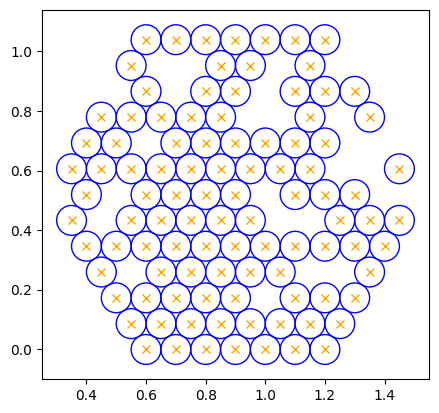

In [43]:
n = 100
k = 1 / pow(n, 0.5)

grid = Grid(n, k)

fig, ax = plt.subplots(figsize=(5, 5))
ax.set_aspect("equal")

for h in grid.points:
    x, y = h.hex2xy(k)
    ax.plot(x, y, "x", color="orange")
    circle = plt.Circle((x, y), k / 2, color="blue", fill=False)
    ax.add_artist(circle)
# x = 0.30
# y = 0.46
# ax.plot(x, y, "x", color="red")
# hex0 = Hex.xy2hex(x, y, k)
# print(hex0)
# ax.plot(*hex0.hex2xy(k), "x", color="green")
plt.xlim(
    min(h.hex2xy(k)[0] for h in grid.points) - k,
    max(h.hex2xy(k)[0] for h in grid.points) + k,
)
plt.ylim(
    min(h.hex2xy(k)[1] for h in grid.points) - k,
    max(h.hex2xy(k)[1] for h in grid.points) + k,
)
plt.show()

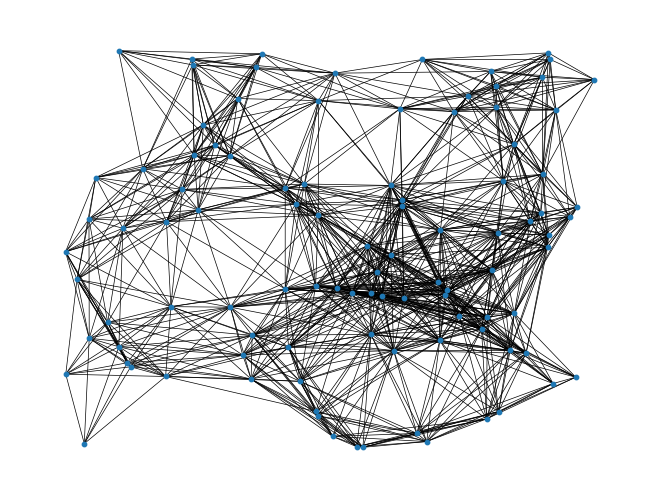

In [29]:
G = nx.random_geometric_graph(100, 0.3, seed=0)

pos = np.array([G.nodes[i]["pos"] for i in G.nodes])
nx.draw(G, pos, node_size=10, width=0.5)
plt.show()

dim = 2
G, center = _process_params(G, None, dim)

A = nx.to_scipy_sparse_array(G, dtype="f")
n = G.number_of_nodes()
nodes = np.arange(n)
np.random.shuffle(nodes)
A = A[nodes][:, nodes]
k = 1 / np.sqrt(n)
A = scipy.sparse.coo_matrix(A)
assert np.all(A.data >= 0)

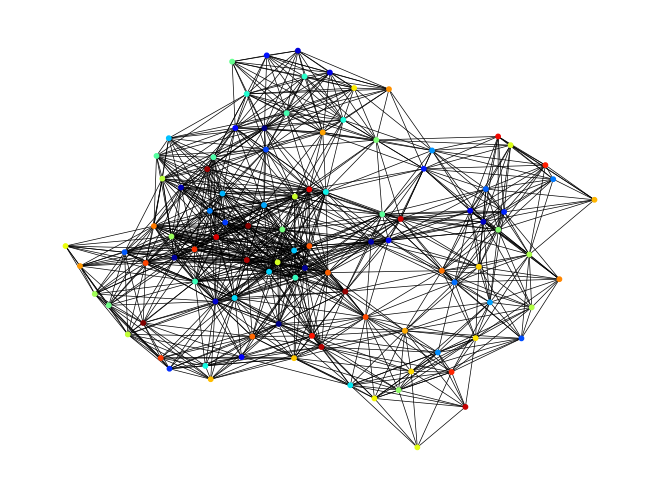

In [30]:
pos = nx.kamada_kawai_layout(G)
visGraph(G, pos, node_size=10, width=0.5)

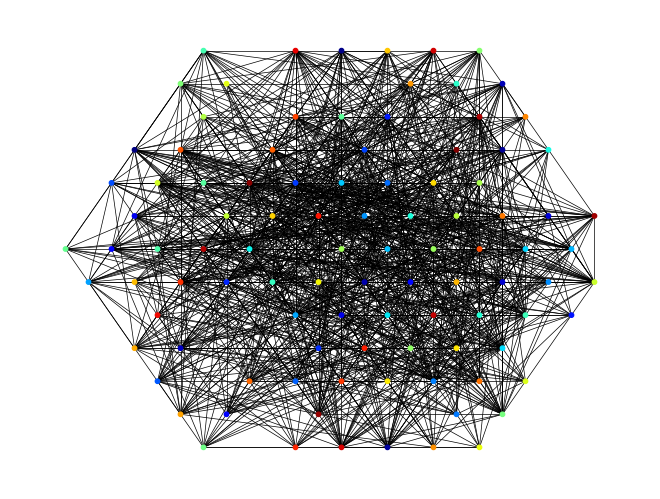

In [32]:
import random


def points2pos(points: List[Hex], k: float) -> np.ndarray:
    return np.array([h.hex2xy(k) for h in points])


visGraph(G, points2pos(points, k), node_size=10, width=0.5)